### Pareto Chart

In [1]:
# This gist contains a direct connection to a local PostgreSQL database
# called "suppliers" where the username and password parameters are "postgres"

# This code is adapted from the tutorial hosted below:
# http://www.postgresqltutorial.com/postgresql-python/connect/

import psycopg2
import pandas as pd
# Establish a connection to the database by creating a cursor object
# The PostgreSQL server must be accessed through the PostgreSQL APP or Terminal Shell

# conn = psycopg2.connect("dbname=suppliers port=5432 user=postgres password=postgres")

# Or:
conn = psycopg2.connect(host="localhost", port = 5432, database="ecommerce", user="postgres", password="b197eas")

# Create a cursor object
cur = conn.cursor()

# A sample query of all data from the "vendors" table in the "suppliers" database

# # Close the cursor and connection to so the server can allocate
# # bandwidth to other requests
# cur.close()
# conn.close()

In [2]:
#Example to use put query results into pandas df
cur.execute("""SELECT sales,user_name FROM datawarehouse.fact_sales fs, datawarehouse.dim_user du where fs.user_key = du.user_key""")
query_results = cur.fetchall()
df = pd.DataFrame (query_results, columns =['sales','username'])
df.head()

,sales,username
0,92500.0,ea9b6e80b1f0c7dffa5f4c3dbd681db7
1,119700.0,9eb77967122094a4eea4084933b47a1e
2,24990.0,9f10a450cddebea0e7cd86f67c894d1c
3,98000.0,5b5c5e6acbc294d9c30645e963c2c371
4,29000.0,235baa608e478f28346f4f732009e013


In [3]:
from pandasql import sqldf
output = sqldf("select count(distinct username) from df")
output

,count(distinct username)
0,95420


In [4]:
output = sqldf("select count( username) from df")
output

,count( username)
0,112650


In [5]:
agg = sqldf("select username, sum(sales) as sales from df group by 1 order by 2 desc")
agg

,username,sales
0,0a0a92112bd4c708ca5fde585afaa872,13440000.0
1,da122df9eeddfedc1dc1f5349a1a690c,7388000.0
2,763c8b1c9c68a0229c42c9fc6f662b93,7160000.0
3,dc4802a71eae9be1dd28f5d788ceb526,6735000.0
4,459bef486812aa25204be022145caa62,6729000.0
...,...,...
95415,cf3839da0d9492ad151690b65f45d800,2990.0
95416,bd06ce0e06ad77a7f681f1a4960a3cc6,2290.0
95417,317cfc692e3f86c45c95697c61c853a6,2200.0
95418,d80730c15c647bc8f2ad77c908ba5ca9,850.0


In [6]:
0.2 * 95420

19084.0

In [7]:
total_sales = agg['sales'].sum() 

In [8]:
# Top 20 %
top20df = sqldf("select username, sales from agg order by 2 desc limit 19084")
top20sales = top20df['sales'].sum() 

top20sales / total_sales

0.5675707096412482

In [9]:
0.45 * 95420

42939.0

In [10]:
# Top 45 %
top45df = sqldf("select username, sales from agg order by 2 desc limit 42939")
top45sales = top45df['sales'].sum() 

top45sales / total_sales

0.8007951142804016

In [11]:
import math

millnames = ['',' Thousand',' Million',' Billion',' Trillion']

def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

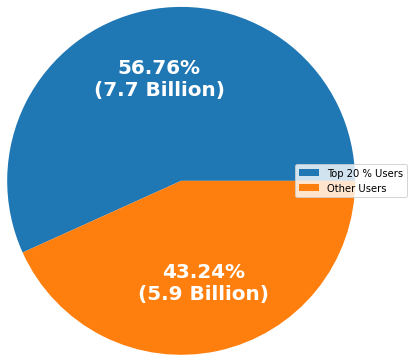

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl 


fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))

data = [top20sales, (total_sales-top20sales)]
legends = ['Top 20 % Users',"Other Users" ]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    temp = millify(absolute)
    return "{:.2f}%\n({})".format(pct, temp)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops={'color': 'w'}, radius=2)
texts[-1].set_fontsize(60)

ax.legend(wedges, legends,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=20, weight="bold")
plt.show()


In [13]:
texts

[Text(-0.463515465572256, 2.1506169843036522, ''),
 Text(0.4635150628616604, -2.150617071098514, '')]

In [14]:
0.05 * 95420

4771.0

In [15]:
# Top 5 %
topdf = sqldf("select username, sales from agg order by 2 desc limit 4771")
topsales = topdf['sales'].sum() 

In [16]:
topsales

3975460980.0

In [17]:
N = 4771
bar_data = agg.groupby(agg.index // N).sum()
bar_data

,sales
0,3.975461e+09
1,1.628749e+09
2,1.172063e+09
3,9.379461e+08
4,8.015858e+08
5,6.988117e+08
6,6.195963e+08
7,5.555443e+08
8,4.943649e+08
9,4.483573e+08


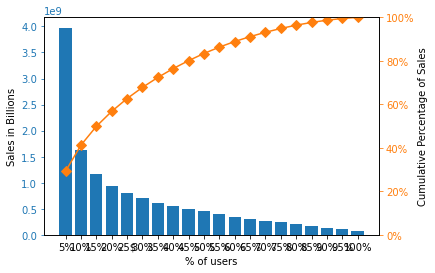

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import figure

df = bar_data
df.index = ['5%', '10%', '15%', '20%', '25$', '30%', '35%', '40%', '45%','50%','55%','60%','65%','70%','75%','80%','85%','90%','95%','100%']
df["cumpercentage"] = df["sales"].cumsum()/df["sales"].sum()*100


fig, ax = plt.subplots()
ax.bar(df.index, df["sales"], color="C0")
ax.set_xlabel("% of users")
ax.set_ylabel("Sales in Billions")

ax2 = ax.twinx()
ax2.plot(df.index, df["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylim([0, 100])
ax2.set_ylabel("Cumulative Percentage of Sales")

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")


plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [19]:
# Top 20% Product
#Example to use put query results into pandas df
cur.execute("""SELECT sum(sales),product_id FROM datawarehouse.fact_sales fs, datawarehouse.dim_product du where fs.product_key = du.product_key group by 2 order by 1 desc""")
query_results = cur.fetchall()
prod = pd.DataFrame (query_results, columns =['sales','product_id'])
prod

,sales,product_id
0,63885000.0,bb50f2e236e5eea0100680137654686c
1,54730200.0,6cdd53843498f92890544667809f1595
2,48899300.0,d6160fb7873f184099d9bc95e30376af
3,47214600.0,d1c427060a0f73f6b889a5c7c61f2ac4
4,43025600.0,99a4788cb24856965c36a24e339b6058
...,...,...
32946,2990.0,2e8316b31db34314f393806fd7b6e185
32947,2900.0,680cc8535be7cc69544238c1d6a83fe8
32948,2550.0,8a3254bee785a526d548a81a9bc3c9be
32949,2290.0,310dc32058903b6416c71faff132df9e


In [20]:
0.2 * 32951

6590.200000000001

In [21]:
totalprod = prod['sales'].sum()

In [22]:
# Top Prod
top20prod = sqldf("select product_id, sales from prod order by 2 desc limit 6590")
top20sales_prod = top20prod['sales'].sum() 

top20sales_prod / totalprod

0.7483127077856632

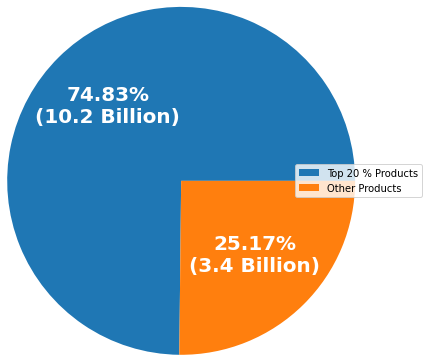

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl 


fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))

data = [top20sales_prod, (totalprod-top20sales_prod)]
legends = ['Top 20 % Products',"Other Products" ]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    temp = millify(absolute)
    return "{:.2f}%\n({})".format(pct, temp)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops={'color': 'w'}, radius=2)
texts[-1].set_fontsize(60)

ax.legend(wedges, legends,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=20, weight="bold")
plt.show()


In [24]:
#Example to use put query results into pandas df
cur.execute("""SELECT user_name, order_frequency FROM datamarts.rfm fs""")
query_results = cur.fetchall()
df = pd.DataFrame (query_results, columns =['user_name','order_frequency'])
df

,user_name,order_frequency
0,0037eb1ff742ee2e71ba887f65f3c6f3,1
1,003800162424b7b5b3d75c9cf22a66e7,1
2,00391594070baf8603f5fdc1d0c6a48c,1
3,003c457932a554e4df13834237b1ed00,1
4,003db7adfcdc49857b095a50191b6c9d,1
...,...,...
95415,ffe9e41fbd14db4a7361347c56af5447,1
95416,ffebb6424578e7bb153322da9d65634f,1
95417,fff3a9369e4b7102fab406a334a678c3,1
95418,fffcf5a5ff07b0908bd4e2dbc735a684,1


In [25]:
cur.execute("""SELECT user_name, order_recency FROM datamarts.rfm fs where order_frequency > 1 and order_recency > '2018-01-01'""")
query_results = cur.fetchall()
df3 = pd.DataFrame (query_results, columns =['user_name','order_frequency'])
df3

,user_name,order_frequency
0,012452d40dafae4df401bced74cdb490,2018-05-14
1,01f2285f85a1c603eb7ef755ad311769,2018-05-31
2,02b20b7c813efede140142ac610e36dc,2018-03-19
3,02fbe4db886eb98774c8ba300d39fa79,2018-02-17
4,035e7cd88b7450fd33efeca817081a53,2018-07-02
...,...,...
1738,fc2261ae2c583aa2e68241456a6467c8,2018-05-13
1739,fc24db02becd484accefaa5af59c18b1,2018-06-25
1740,fcd0ab79592faab19e2bf386cf69fbcd,2018-04-07
1741,fde381fe79993303957d1fcf9cd6bf4a,2018-05-03


In [26]:
cur.execute("""SELECT user_name, order_frequency FROM datamarts.rfm fs where order_frequency > 1""")
query_results = cur.fetchall()
df2 = pd.DataFrame (query_results, columns =['user_name','order_frequency'])
df2

,user_name,order_frequency
0,012452d40dafae4df401bced74cdb490,2
1,01f2285f85a1c603eb7ef755ad311769,2
2,02b20b7c813efede140142ac610e36dc,2
3,02fbe4db886eb98774c8ba300d39fa79,2
4,031ea691b99fc101dcad357d1a83573f,2
...,...,...
2908,fde381fe79993303957d1fcf9cd6bf4a,2
2909,fe613188d4d20ea3e3dc1290549c3ad1,2
2910,fed519569d16e690df6f89cb99d4e682,2
2911,ff44401d0d8f5b9c54a47374eb48c1b8,2


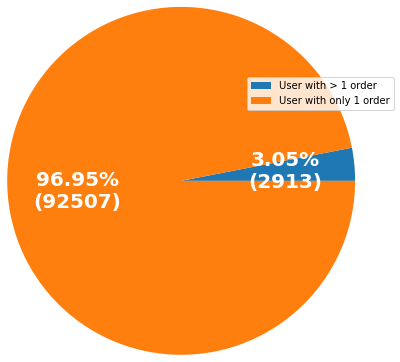

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl 


fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))

data = [2913, 95420 - 2913]
legends = ['User with > 1 order',"User with only 1 order" ]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.2f}%\n({})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops={'color': 'w'}, radius=2)
texts[-1].set_fontsize(60)

ax.legend(wedges, legends,
          loc="best",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=20, weight="bold")
plt.show()


In [30]:

cur.execute("""select user_name from datamarts.rfm r where order_frequency > 1 """)
query_results = cur.fetchall()
tempdf = pd.DataFrame (query_results, columns =['user_name'])
tempdf

,user_name
0,012452d40dafae4df401bced74cdb490
1,01f2285f85a1c603eb7ef755ad311769
2,02b20b7c813efede140142ac610e36dc
3,02fbe4db886eb98774c8ba300d39fa79
4,031ea691b99fc101dcad357d1a83573f
...,...
2908,fde381fe79993303957d1fcf9cd6bf4a
2909,fe613188d4d20ea3e3dc1290549c3ad1
2910,fed519569d16e690df6f89cb99d4e682
2911,ff44401d0d8f5b9c54a47374eb48c1b8
